In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import sys, os
sys.path.append("../core-scripts")
import Utilities

In [388]:
DATA_PATH = "./data/3D-shear-FULL-kx_0-1_kz0.7"

data = np.load(os.path.join(DATA_PATH, "spectra-mat.npy"))
gds = np.load(os.path.join(DATA_PATH, "gds.npy"))
kxs = np.load(os.path.join(DATA_PATH, "kxs.npy"))
acts = np.load(os.path.join(DATA_PATH, "acts.npy"))

In [587]:
def real_err(ev1, ev2):
        # Only compare the 10 values near the pruning pointers
        return np.linalg.norm(ev1[:5].real - ev2[:5].real)

def extract_max_k(low_evals, high_evals):
    _, ptr1, ptr2 = Utilities.prune_evs(low_evals, high_evals)
    low_max, _ = Utilities.max_re(low_evals[ptr1:])
    high_max, _ = Utilities.max_re(high_evals[ptr2:])
    return Utilities.max_re(np.array([low_max, high_max]))[0]

def sift_evs(data_low, data_high):
    accepted = []
    diff_disp = []
    for i in range(len(data_low)-20):
        diffs = abs(data_low[i].real - data_high.real)
        amin = np.argmin(diffs)
        # print(amin, data_high[amin])
        if diffs[amin] < 0.01:
            displace_diff = np.linalg.norm(data_low[i:i+5].real - data_high[amin:amin+5].real)/5
            # print(i, amin, )
            accepted.append((i,amin))
            diff_disp.append(displace_diff)
    pair = ()
    for i in range(len(diff_disp)):
        if diff_disp[i]<1e-4:
            pair = accepted[i]
            break
    if len(pair)==0:
         return -1
    return Utilities.max_re(np.array([data_low[pair[0]], data_high[pair[1]]]))[0]

        
def extract_based_on_diff(low_ev, high_ev):
    diffs = np.diff(low_ev.real)
    start_idx = -1
    for i in range(len(low_ev)-2, -1, -1):
        if np.abs(diffs[i]) > 11*np.median(np.abs(diffs)):
            start_idx = i+1
            break
    nearest_delta = np.min(np.abs(low_ev[start_idx].real - high_ev.real))
    if not start_idx==-1:
        while nearest_delta>0.2:
            start_idx += 1
            nearest_delta = np.min(np.abs(low_ev[start_idx].real - high_ev.real))
    return 0 if start_idx==-1 else start_idx

In [588]:
spec_k = np.zeros((len(kxs), len(gds), len(acts)), dtype=np.complex128)
spec = np.zeros((len(gds), len(acts)), dtype=np.complex128)

for i in range(len(gds)):
    for j in range(len(acts)):
        for k in range(len(kxs)):
            low_evals = np.copy(data[k,i,j,0,:])
            high_evals = data[k,i,j,1,:]
            # low_evals[low_evals.real > 1] = -1
            start_idx = extract_based_on_diff(low_evals, high_evals)
            spec_k[k,i,j] = low_evals[start_idx]
            # spec_k[k,i,j] = extract_max_k(low_evals, high_evals)
            # spec_k[k,i,j] = sift_evs(low_evals, high_evals)

for i in range(len(gds)):
    for j in range(len(acts)):
        spec[i,j] = Utilities.max_re(spec_k[:,i,j])[0]

Text(0.5, 1.0, '$Re(\\sigma)$')

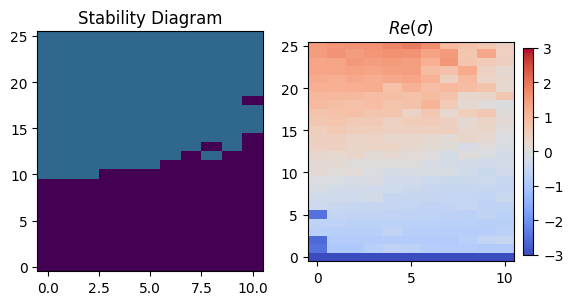

In [589]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(spec.T.real>0, aspect=0.45, vmax = 3, origin='lower')
evs_plot = axs[1].imshow(spec.T.real, aspect=0.45, vmax = 3, origin='lower', cmap='coolwarm')
plt.colorbar(evs_plot, ax=axs[1],fraction=0.046, pad=0.04)
axs[0].set_title("Stability Diagram")
axs[1].set_title("$Re(\sigma)$")

0
0.0448015204279697
7
(-0.024452608733069137-0.3540540988033017j)


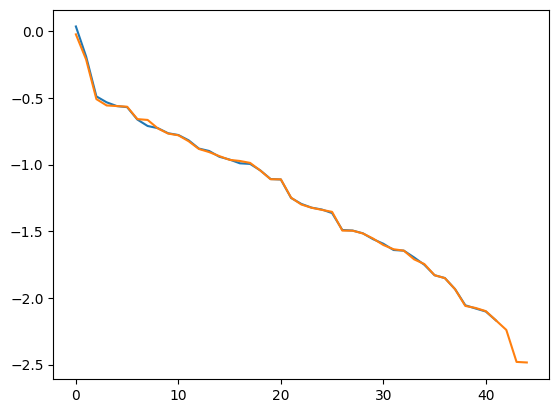

In [583]:
k,i,j = 2,9,13
data_low = np.copy(data[k,i,j,0,:])
data_high = np.copy(data[k,i,j,1,:])
# plt.plot(data_low.real[3:])
# data_low[data_low.real > 1] = -1
diffs = np.diff(data_low.real)
print(np.median(np.abs(diffs)))
# plt.plot(np.diff(data_low.real))
start_idx = -1
for i in range(len(data_low)-2, -1, -1):
    if np.abs(diffs[i]) > 10*np.median(np.abs(diffs)):
        start_idx = i+1
        break
print(start_idx)
plt.plot(data_low[start_idx+1:].real)
plt.plot(data_high[5:].real)
print(data_high[5])
# plt.plot(np.diff(data_low.real[start_idx-1:]))
# plt.plot(data_high.real[4:])
# print(data_low[start_idx])
# accepted = []
# diff_disp = []
# for i in range(len(data_low)-20):
#     diffs = abs(data_low[i].real - data_high.real)
#     amin = np.argmin(diffs)
#     # print(amin, data_high[amin])
#     if diffs[amin] < 0.01:
#         displace_diff = np.linalg.norm(data_low[i:i+5].real - data_high[amin:amin+5].real)/5
#         # print(i, amin, )
#         accepted.append((i,amin))
#         diff_disp.append(displace_diff)
# for i in range(len(diff_disp)):
#     if diff_disp[i]<1e-4:
#         pair = accepted[i]
#         print(accepted[i])
#         # plt.plot(data_low.real[pair[0]:], 'x--')
#         # plt.plot(data_high[pair[1]:].real, '.--')
#         break
# print(accepted)
# plt.plot(np.arange(4, 4+len(data_low)), data_low.real, 'x--')
# plt.plot(np.arange(7, 7+len(data_high)), data_high.real, '.--')
# plt.plot(data_low.real[9:], 'x--')
# plt.plot(data_high[5:].real, '.--')
# print(Utilities.max_re(np.array(accepted))[0])

# plt.plot(data_low.real, '.--')
# plt.plot(np.diff(data_low.real))
# print(ptr1, ptr2)
# remove excessively large values
# align the two spectra, specifically, only take the parts that both spectra agree on... 